# Analyzing Code Performance

### Timing Your Code

In [9]:
def slow_way_to_calculate_mode(list_of_numbers):
    result_dict = {}
    for i in list_of_numbers:
        if i not in result_dict:
            result_dict[i] = 1
        else:
            result_dict[i] += 1

    mode_vals = []
    max_frequency = max(result_dict.values())
    for key, value in result_dict.items():
        if value == max_frequency:
            mode_vals.append(key)

    return mode_vals

In [10]:
slow_way_to_calculate_mode([4, 5, 5, 6])

[5]

In [11]:
import numpy as np

random_integers = np.random.randint(1, 1_000_000, 1_000_000)

In [33]:
import time

start = time.time()
slow_way_to_calculate_mode(random_integers)
end = time.time()

print(end - start)

0.039128780364990234


In [38]:
%%timeit
slow_way_to_calculate_mode(random_integers)

31.3 ms ± 514 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In this case, timeit looped through the code 10 times, and it repeated the set of 10 loops 7 times, then returned the summary statistics of those runs. timeit defaults to the number of runs and loops that will fit into a 2-second window, but you can specify the number of runs using the -r flag and the number of loops using the -n flag.
If you’re using a standalone script, you can use timeit as shown in this example:

In [45]:
import numpy as np
import timeit

random_integers = np.random.randint(1, 100_000, 100_000)

def slow_way_to_calculate_mode(list_of_numbers):
    result_dict = {}
    for i in list_of_numbers:
        if i not in result_dict:
            result_dict[i] = 1
        else:
            result_dict[i] += 1

    mode_vals = []
    max_frequency = max(result_dict.values())
    for key, value in result_dict.items():
        if value == max_frequency:
            mode_vals.append(key)

    return mode_vals

mode_timer = timeit.Timer(stmt="slow_way_to_calculate_mode(random_integers)",
                          setup="from __main__ import slow_way_to_calculate_mode, random_integers")

time_taken = mode_timer.timeit(number=10)

print(f"Execution time: {time_taken} seconds")


Execution time: 0.36447689999477006 seconds


But is this code any good? Is this fast or slow? Because this is just an example without real-world requirements for speed, I’ll compare it with another way of calculating the mode and see if that improves the performance. Here’s another way to carry out the same calculation:

In [46]:
from collections import Counter

def mode_using_counter(list_of_numbers):
    c = Counter(list_of_numbers)
    return c.most_common(1)[0][0]

And again using timeit to measure how long it takes to run:

In [48]:
%%timeit
mode_using_counter(random_integers)

22.1 ms ± 641 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


As you can see, this version of the code takes much less time to run. Instead of an average of approximately 267 ms, it takes only approximately 22 ms. The standard deviation is also much lower, which helps guarantee an upper bound to the runtime.

## Profiling Your Code

### `cProfile`

`cProfile` is the built-in profiler for Python, and you can use it to get a basic overview of the locations of bottlenecks in a longer script. In this example, I’ll put the random number generator inside the mode function from the previous section so that there’s more to see in the profiler:

In [50]:
from collections import Counter
import numpy as np

def mode_using_counter(n_integers):
    random_integers = np.random.randint(1, 100000, n_integers)
    c = Counter(random_integers)
    return c.most_common(1)[0][0]

In [51]:
mode_using_counter(10000000)

71780

In [52]:
%%timeit
mode_using_counter(10000000)

4.1 s ± 1.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
%%prun
mode_using_counter(10000000)

         23 function calls in 3.355 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    3.216    3.216    3.216    3.216 {built-in method _collections._count_elements}
        1    0.124    0.124    0.124    0.124 {method 'randint' of 'numpy.random.mtrand.RandomState' objects}
        1    0.009    0.009    3.355    3.355 <string>:1(<module>)
        1    0.007    0.007    0.007    0.007 {built-in method builtins.max}
        1    0.000    0.000    3.355    3.355 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    3.346    3.346 3965975765.py:4(mode_using_counter)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:71(_wrapreduction)
        1    0.000    0.000    0.007    0.007 __init__.py:588(most_common)
        1    0.000    0.000    0.007    0.007 heapq.py:521(nlargest)
        1    0.000    0.000    3.

The `tottime` column in this output shows where the computer spent most of the time when running this code: in the built-in method `_collections._count_elements` function, which is the Counter function. The next most time-consuming part was method 'randint' of 'numpy.random.mtrand.RandomState' objects, which is the step that created the list of random numbers. All the other steps took very little time. The disadvantage of using cProfile is that you need to map each of these function calls back to lines within your code.

In [54]:
%load_ext snakeviz

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [57]:
%%snakeviz
mode_using_counter(1000000)

 
*** Profile stats marshalled to file 'C:\\Users\\anpande\\AppData\\Local\\Temp\\tmpl7z03qf2'.
Embedding SnakeViz in this document...
<function display at 0x00000289C0F06DD0>


`line_profiler`

`cProfile` gives you a detailed breakdown of how the computer spends its time, including details of Python’s internal workings. However, its output is not particularly easy to read and may dive too deep into Python built-in methods called by your code. The package `line_profiler` gives a much more readable breakdown of your code.

In [24]:
%load_ext line_profiler

You need to explicitly tell line_profiler which function to look at using the `-f` flag, and you can run the function using this command:

In [58]:
%lprun -f mode_using_counter mode_using_counter(10000000)

Timer unit: 1e-07 s

Total time: 3.38414 s
File: C:\Users\anpande\AppData\Local\Temp\ipykernel_19796\3965975765.py
Function: mode_using_counter at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def mode_using_counter(n_integers):
     5         1    1223410.0    1e+06      3.6      random_integers = np.random.randint(1, 100000, n_integers)
     6         1   32534264.0    3e+07     96.1      c = Counter(random_integers)
     7         1      83681.0  83681.0      0.2      return c.most_common(1)[0][0]

## Memory Profiling 

You can profile your code’s memory usage as well as the time it takes to run. Memory usage is something you also may need to optimize, depending on your code’s requirements. It’s important to consider this as the size of your data increases, because you may hit the upper limits of the hardware you are using. Additionally, the CPU has to work harder to manage memory. This could increase the runtime of your code if the CPU is spending too much time managing the memory instead of executing code.


## Time Complexity

What happens if you expect the amount of data to grow in the future? Or what if parts of your code take so long to run that it’s not feasible to measure them? The concept of time complexity can help you here.

Time complexity describes how the running time of an algorithm grows as the size of the input increases. This means an overall trend, not specific to any hardware. To make this more concrete, consider this question: if you run your code on a list of numbers, then double the length of the list, what happens to the runtime of the code? Does it stay the same, or does it double, or something else?

### How to Estimate Time Complexity
Here’s an example. This function calculates a weighted mean, taking as input a list of numbers and a list of weights to apply to those numbers:


In [26]:
def weighted_mean(list_of_numbers, weights):
    running_total = 0
    for i in range(len(list_of_numbers)):
        running_total += (list_of_numbers[i] * weights[i])
    return (running_total/sum(weights))

If the length of `num_list` doubles, the number of iterations in the for loop also doubles. The other lines in this function (initializing the running total and dividing it by the length of the list) don’t increase their runtime. You could think about this as an equation for the runtime of the code in terms of the number of steps in this function, where each step is some operation carried out by the code. Initializing the running total is one step, each time the running total is added to constitutes another step, and returning the result is another step. 

The equation would be:

`number_of_steps = n + 2` where n is the length of the input lists

So as the size of n increases, the number of steps grows linearly but the 2 remains constant.


The following function accepts two lists as inputs and calculates their covariance (a measure of the strength of the correlation between two random variables). Again, this isn’t the best way to calculate this; the function is just to illustrate the point:

In [ ]:
def covariance(X, Y):
    cov_sum = 0
    for i in range(len(X)):
        for j in range(len(Y)):
            cov_sum += 0.5 * (X[i] - X[j]) * (Y[i] - Y[j])
    return cov_sum / (len(X) ** 2)

Because there are two nested (one inside the other) for loops in this function, if the sizes of both X and Y double, the number of steps taken to calculate the result increases fourfold. X and Y both must be the same length in this function. 

The running time of the code increases proportionally to the square of the increase in the size of the dataset. The following suggests a way to improve the runtime using only one for loop. 

In [ ]:
def covariance_fast(X, Y):
    avg_X = sum(X) / len(X)
    avg_Y = sum(Y) / len(Y)

    result = 0
    for i in range(len(X)):
        result += (X[i] - avg_X) * (Y[i] - avg_Y)

    return result / len(X)

In [28]:
import numpy as np
X = np.random.randint(1, 1000, 1000)
Y = np.random.randint(1, 1000, 1000)

In [29]:
%%timeit
covariance_fast(X, Y)

908 µs ± 148 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
%%timeit
covariance(X, Y)

3.17 s ± 563 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Code to generate Big-O Chart

In [7]:
import matplotlib.pyplot as plt
import numpy as np

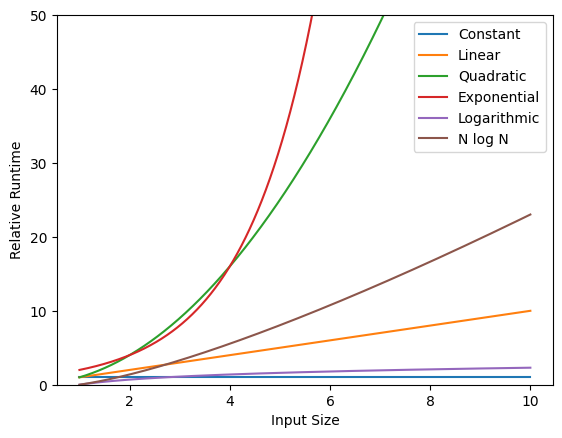

In [8]:
n = np.linspace(1, 10, 1000)
line_names = [
    "Constant",
    "Linear",
    "Quadratic",
    "Exponential",
    "Logarithmic",
    "N log N",
]
big_o = [np.ones(n.shape), n, n**2, 2**n, np.log(n), n * (np.log(n))]

fig, ax = plt.subplots()
fig.set_facecolor("white")

ax.set_ylim(0, 50)
for i in range(len(big_o)):
    ax.plot(n, big_o[i], label=line_names[i])
ax.set_ylabel("Relative Runtime")
ax.set_xlabel("Input Size")
ax.legend()
fig.savefig("ch02_02.png", bbox_inches="tight")